# Particle Identification studies

In this notebook, we will study in more details the particle identification techniques that were mentioned in the previous notebook (RICH-based, LKr-based, MUV3-based)

In [1]:
# Lets first import all we need
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from na62 import prepare, hlf, extract, constants, stats

In [2]:
# Then we read the data. This will give us a dataframe which contains the data from all the root files we provided
data, _ = prepare.import_root_files(["data/run12450.root"])

## RICH-based PID

In the previous notebook, we have determined the mapping between the `rich_hypothesis` values and their meaning, which we can remind ourselves here:

In [3]:
constants.rich_hypothesis_map

{'bckg': 0, 'e': 1, 'mu': 2, 'pi': 3, 'k': 4, 'mult': 99}

Let's have a more detailed look about this technique. How does it work?

As you know from your detector course, a particle travelling in a medium at a speed higher than the speed of ligh **in the medium** will generate a cone of Cherenkov light. The opening angle of the cone depends on multiple parameters (the pressure-dependent medium refractive index $n(pressure)$, and the particle speed $v$) in the relation $cos\theta_\text{c} = \frac{c}{nv}$. In the NA62 RICH, the light in the Cherenkov cone is reflected by mirrors on the end-wall onto disks of photo-multipliers (PMTs) located in the front-wall. These disks will detect the photons and, using the PMTs position, we can reconstruct a ring whose diameter is directly proportional to the Cherenkov cone opening angle. The proportionality factor is the focal length of the mirrors (17 m in NA62 RICH). The particle speed not being a very relevant parameter in this context, we can express it instead in terms of the mass $m$ and the momentum $p$: $v = p/E = p/\sqrt{m^2 + p^2}$. Substituting this into the Cherenkov angle expression we get $cos\theta_\text{c} = \frac{c\sqrt{m^2 + p^2}}{np}$. 

In NA62, as already mentioned, the refrative index is chosen to give the best performances in the momentum range $15~\text{GeV} < p < 40~\text{GeV}$ (corresponding to the most likely range for the $\pi^+$ momentum in the $K^+\to\pi^+\nu\bar{\nu}$ decay). The medium used is neon at a pressure of 1 atmosphere. In this latest expression, the value of $n$ is therefore fixed, the particle momentum is measured independently by the STRAW spectrometer, and you can see that the Cherenkov angle then depends only on the particle mass, providing us with a nice way to identify particles.

As an exercise, please implement below a function that will give us the ring diameter as a function of the particle mass and momentum:

In [4]:
from typing import Union

def ring_radius(p: Union[float, np.array, pd.Series], mass: float) -> Union[float, np.array, pd.Series]:
    n = 1.000063 # Refractive index in NA62
    f = 17*1000  # Focal lenght in NA62 (17m)
    c = 1        # Light speed in natural units

    # [FILL HERE]
    # Compute the ring radius as a function of the momentum and mass provided
    # in input. 
    # All the NA62 specific values that are needed in the equation are provided 
    # above: refractive index, focal length and speed of light (as a gift)
    
    return # [SOMETHING]

Below we are going to extract all the tracks that are available to us in these data and plot the ring radius as a function of the momentum.
We are also going to plot the theoretical values computed by your function for all the particles we could see in NA62 ($e/\mu/\pi/K/p$). 

/home/nlurkin/jupyter/NA62_UCL/na62/hlf.py:968: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cost) * f


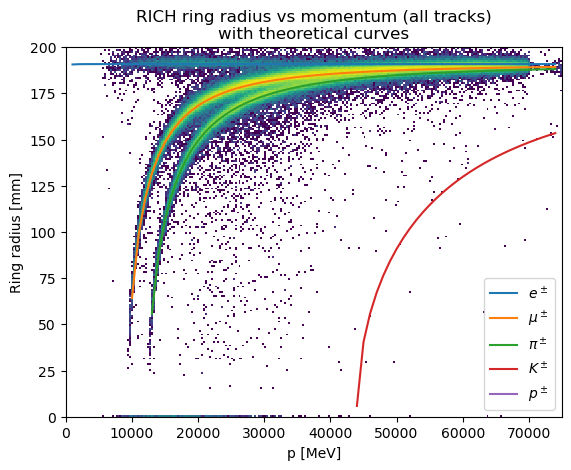

In [5]:
# Get all tracks in the events
all_tracks = extract.all_tracks(data)

# And plot the ring_radius as a function of the momentum
_ = plt.hist2d(all_tracks["momentum_mag"], all_tracks["rich_radius"], cmin=1, bins=(250,200), range=((0,75000),(0,200)), norm=mpl.colors.LogNorm())
plt.title("RICH ring radius vs momentum (all tracks)\nwith theoretical curves")
plt.xlabel("p [MeV]")
plt.ylabel("Ring radius [mm]")

# Generate momentum range between 1 GeV and 75 GeV in steps of 1 GeV
p = np.arange(1000, 75000, 1000)

# Plot the ring radius for the e/pi/mu/K/p masses
plt.plot(p, ring_radius(p, constants.electron_mass), label="$e^\pm$")
plt.plot(p, ring_radius(p, constants.muon_mass), label="$\mu^\pm$")
plt.plot(p, ring_radius(p, constants.pion_charged_mass), label="$\pi^\pm$")
plt.plot(p, ring_radius(p, constants.kaon_charged_mass), label="$K^\pm$")
plt.plot(p, ring_radius(p, constants.proton_mass), label="$p^\pm$")
_ = plt.legend(loc="lower right")

If your function is correctly written, you can observe that the curves for the $e^\pm, \mu^\pm, \pi^\pm$ fit perfectly the three main curves that we ca observe in the data.
The kaon theoretical curve is also present, but we do not see a corresponding data curve. If we had a lot more data and were not preselecting for you some specific decay channels, we could observe a light kaon curve as well.

For the proton on the other hand, you do not even see the theoretical curve. Why do you think that is?
<details>
<summary>Click here to show the answer</summary>
The Cherenkov radiation has a cutoff value. The particle $\beta$ should be higher than $\beta_{th} = 1/n$. In the case of a proton below 75 GeV, we have $\beta < p/E = p/\sqrt{m^2 + p^2} = 0.999922$, which is smaller than $\beta_{th} = 1/n = 0.999937$.
Therefore, the proton at any reachable NA62 energy does not produce Cherenkov light in the NA62 RICH.
</details>

Another thing you can observe on the plot is that while your theoretical lines are very thin, the data curves actually have a certain width. This corresponds to the angular resolution and impedes somewhat our ability to distinguish properly between particles. You can see that up to ~30 GeV we can reasonably well separate the particles by eye. Between 30 GeV and 40 GeV this is becoming a little bit more complicated and we can expect already some occasional mixing between the different curves, resulting in wrong particle identification. Above 40 GeV the curves are completely degenerate and we have completely lost PID capabilities.

The simplest PID algorithm using the RICH is to identify rings of hits on the RICH and for each of these rings measure the radius. Knowing the momentum of the particle and the curves above, we can then assign an hypothesis to the ring.

In practice it is more complicated:
 - The rings are made of only a few hits (11 hits on average). Instead of a clean, nice ring we may therefore have only a partial ring. This complicates both identification of a ring, and the measurement.
 - We need to take into account the resolution on the ring radius
 - If we have multiple particles passing through the RICH, this will leave multiple rings, leading to two main complications
   - The ring identification is more difficult as we have multiple overlapping partial rings
   - Even having identified the ring and the radius correctly, to which of the track do we assign each ring?
  
We have developed more complicated algorithms based on likelihood computations. The algorithm are quite long and complicated, relying also on the computation of the expected position of the ring extrapolated from other detectors. The data provided here do not allow to run such complex algorithms. Just remember that the `rich_hypothesis` variable that we are looking at is in fact the result of this likelihood algorithm.

Let's confirm below that the `rich_hypothesis` corresponds to the ring radius curves.

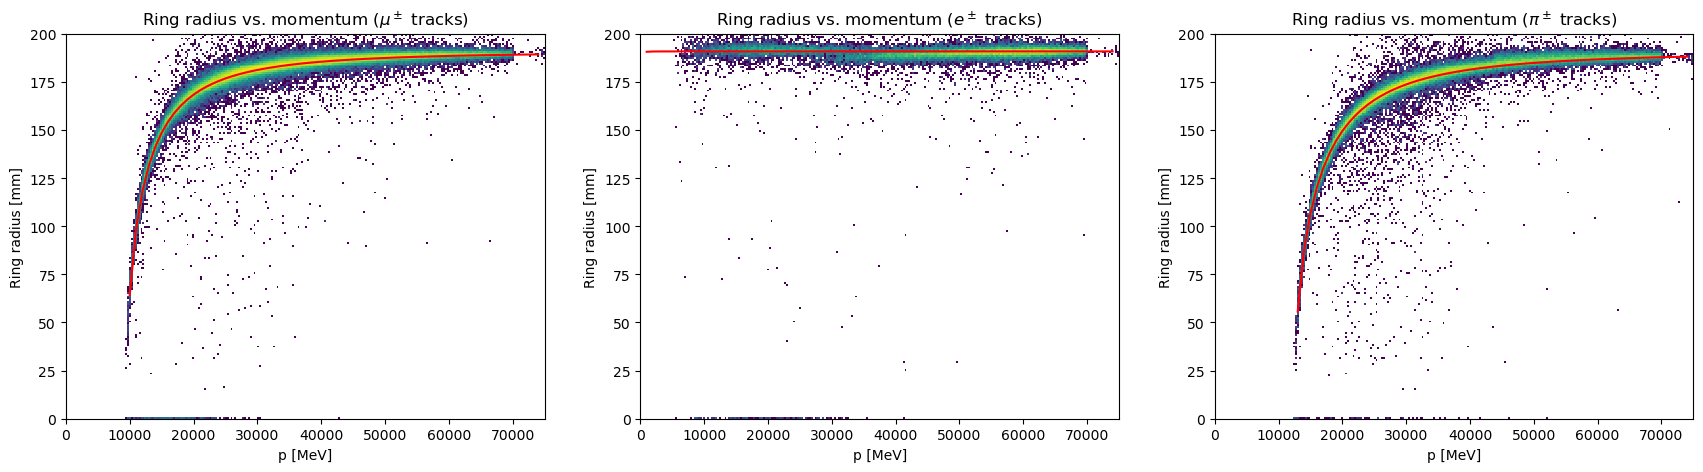

In [6]:
# Isolate the three types of tracks
mu_tracks = all_tracks.loc[all_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["mu"]]
e_tracks = all_tracks.loc[all_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["e"]]
pi_tracks = all_tracks.loc[all_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["pi"]]

# Prepare three plots
fig, ax = plt.subplots(1, 3, figsize=(21,5))

# Plot the muon tracks curve
ax[0].hist2d(mu_tracks["momentum_mag"], mu_tracks["rich_radius"], cmin=1, bins=(250,200), range=((0,75000),(0,200)), norm=mpl.colors.LogNorm())
ax[0].plot(p, ring_radius(p, constants.muon_mass), color="red")
ax[0].set_title("Ring radius vs. momentum ($\mu^\pm$ tracks)") 
ax[0].set_xlabel("p [MeV]")
ax[0].set_ylabel("Ring radius [mm]")

# Plot the electron track curve
ax[1].hist2d(e_tracks["momentum_mag"], e_tracks["rich_radius"], cmin=1, bins=(250,200), range=((0,75000),(0,200)), norm=mpl.colors.LogNorm())
ax[1].plot(p, ring_radius(p, constants.electron_mass), color="red")
ax[1].set_title("Ring radius vs. momentum ($e^\pm$ tracks)") 
ax[1].set_xlabel("p [MeV]")
ax[1].set_ylabel("Ring radius [mm]")

# Plot the pion track curve
ax[2].hist2d(pi_tracks["momentum_mag"], pi_tracks["rich_radius"], cmin=1, bins=(250,200), range=((0,75000),(0,200)), norm=mpl.colors.LogNorm())
ax[2].plot(p, ring_radius(p, constants.pion_charged_mass), color="red")
ax[2].set_title("Ring radius vs. momentum ($\pi^\pm$ tracks)") 
ax[2].set_xlabel("p [MeV]")
_ = ax[2].set_ylabel("Ring radius [mm]")

This looks good, aside from some discontinuity in the electron curve around 35 GeV where we start to loose separation power.

## MUV3-based PID

The MUV3 detector is composed of scintillator tiles located being a thick iron wall. As a result all particles except muons are expected to be absorbed by the wall and only muons will be detected in the MUV3 detector. While this provides no ability to distinguish between electron and pions, this provides an excellent efficiency at identifying muons just by checking if a signal is observed on the detector at the location expected by simple extrapolation of the track position.

This is simply provided through the `has_muv3` variable. We can select all tracks having MUV3 association and check the RICH hypothesis for those track to confirm the compatibility between the two PID methods.

In [7]:
muv3_tracks = all_tracks.loc[all_tracks["has_muv3"]]
muv3_tracks["rich_hypothesis"].value_counts()/len(muv3_tracks)

rich_hypothesis
2     0.747058
3     0.131903
1     0.118305
0     0.001544
99    0.001145
4     0.000044
Name: count, dtype: float64

We see that it is mostly compatible with 76% of MUV3 tracks being identified as $\mu^\pm$ in the RICH, although with quite a sizable contribution from both $e^\pm$ and $\pi^\pm$. However, we know that the RICH is sensitive to the momentum of the particles. Let's plot the momentum for each of of the RICH hypothesis:

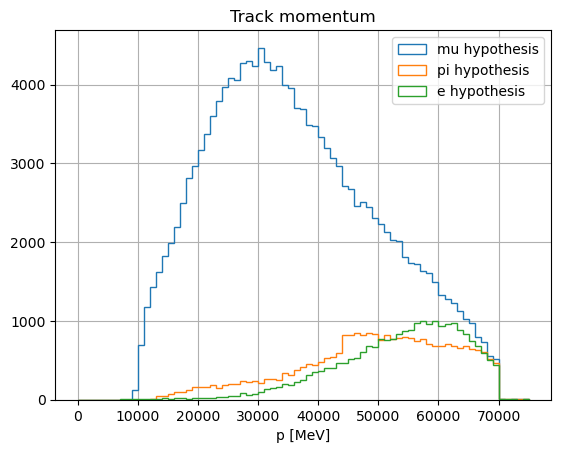

In [8]:
muv3_tracks.loc[muv3_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["mu"], "momentum_mag"].hist(bins=75, range=(0,75000), label="mu hypothesis", histtype="step")
muv3_tracks.loc[muv3_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["pi"], "momentum_mag"].hist(bins=75, range=(0,75000), label="pi hypothesis", histtype="step")
muv3_tracks.loc[muv3_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["e"], "momentum_mag"].hist(bins=75, range=(0,75000), label="e hypothesis", histtype="step")
plt.title("Track momentum")
plt.xlabel("p [MeV]")
_ = plt.legend()

It is rather clear from this that in the majority of the cases where the RICH hypothesis disagrees with the MUV3 hypothesis are tracks that are actually outside the validity range of the RICH detector. 

Let's repeat while limiting ourselves to the correct range (15 GeV to 40 GeV).

In [9]:
# Limit to tracks between 15 GeV and 40 GeV
muv3_tracks = muv3_tracks.loc[(muv3_tracks["momentum_mag"]>15000) & (muv3_tracks["momentum_mag"]<40000)]
# And display the fraction or events for each hypothesis
muv3_tracks["rich_hypothesis"].value_counts()/len(muv3_tracks)

rich_hypothesis
2     0.912276
3     0.058556
1     0.026545
99    0.001507
0     0.001115
Name: count, dtype: float64

This is already much better: 93% efficiency for muons, and 3.5% and 2.5% respectively for the pion/electron hypothesis.

Now let's make a small exercise and look at the efficiency of the MUV3. Let's cheat for now and select only kmu2 event that have been pre-identified and get the muon track. We can compute the detection efficiency (assuming that the selection is independent of MUV3) as the ratio between the kmu2 tracks with signal in MUV3 with respect to all kmu2 tracks.

In [10]:
kmu2 = data.loc[data["event_type"]==constants.event_type_map["kmu2"]]
mu_tracks = extract.track(kmu2, 1)
mu_tracks_with_muv3 = mu_tracks.loc[mu_tracks["has_muv3"] & (np.abs(mu_tracks["time"]-mu_tracks["muv3_time"])<1.5)] # TODO: take into account time cut
print(f"MUV3 efficiency: {len(mu_tracks_with_muv3)/len(mu_tracks):.2%}")

MUV3 efficiency: 96.63%


We can see this is very high, but not 100%, so a small fraction of muon tracks may not be identified correctly using the MUV3 tagging. 
We can check if maybe this efficiency is uniformly distributed on the MUV3. We are going to extrapolate each track to the MUV3 position and compute the efficiency as a function of the extrapolated position (2D efficiency). Here we are going to provide to the `propagate` method the information about the position and direction variables as the MUV3 is located behind the Straw spectrometer magnet.

Text(0, 0.5, 'y [mm]')

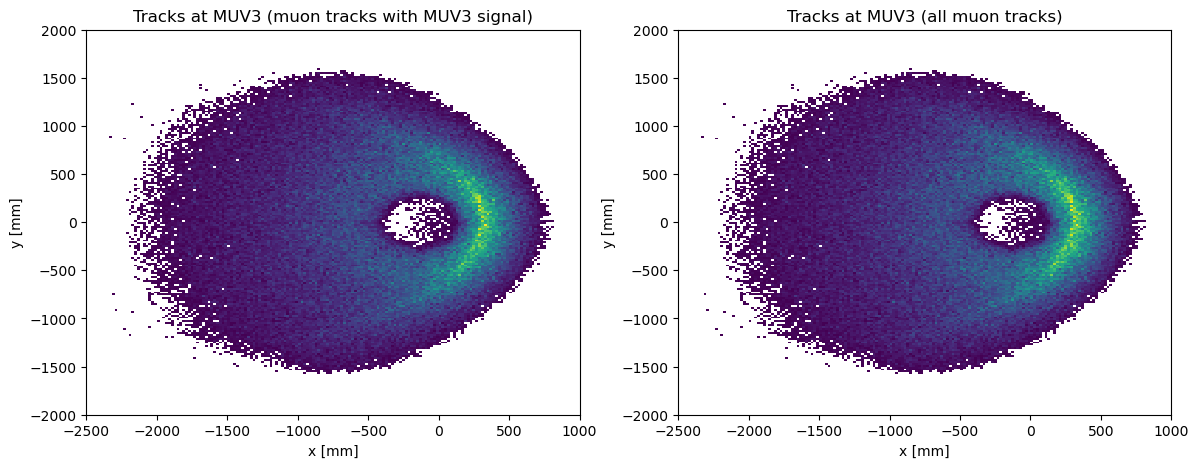

In [11]:
# Propage the tracks to the MUV3 position
mu_tracks_pos = hlf.propagate(mu_tracks, constants.muv3_position, position_field_name="position_am", direction_field_name="direction_am")
mu_tracks_wmuv3_pos = hlf.propagate(mu_tracks_with_muv3, constants.muv3_position, position_field_name="position_am", direction_field_name="direction_am")

# Prepare two plots, one for all the tracks and one for the tracks with MUV3 signal
bins = (175,200)
brange = ((-2500, 1000),(-2000, 2000))
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot tracks with MUV3
h_muv3, binsx, binsy, _ = ax[0].hist2d(mu_tracks_wmuv3_pos["position_x"], mu_tracks_wmuv3_pos["position_y"], cmin=0.1, bins=bins, range=brange)
ax[0].set_title("Tracks at MUV3 (muon tracks with MUV3 signal)")
ax[0].set_xlabel("x [mm]")
ax[0].set_ylabel("y [mm]")

# Plot all tracks
h_all, _,_,_ = ax[1].hist2d(mu_tracks_pos["position_x"], mu_tracks_pos["position_y"], cmin=1, bins=bins, range=brange)
ax[1].set_title("Tracks at MUV3 (all muon tracks)")
ax[1].set_xlabel("x [mm]")
ax[1].set_ylabel("y [mm]")

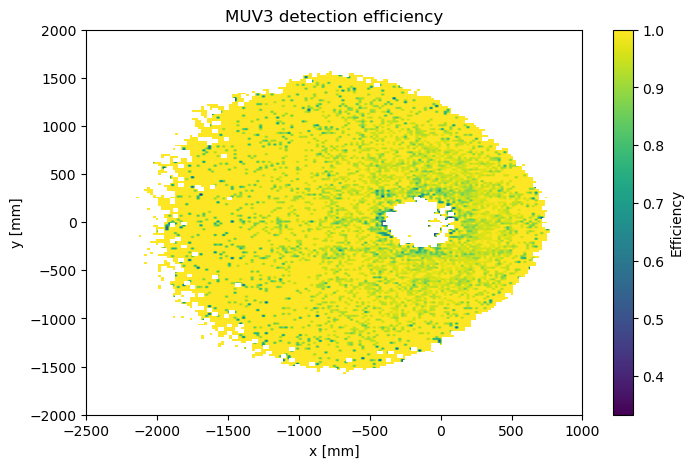

In [12]:
# Compute now the ratio (efficiency)
efficiency = h_muv3/h_all 

# Plot the efficiency
plt.figure(figsize=(8, 5))
plt.imshow(efficiency.T.clip(0, 1), extent=[binsx[0], binsx[-1], binsy[0], binsy[-1]], aspect="auto")
plt.colorbar(label="Efficiency")
plt.title("MUV3 detection efficiency")
plt.xlabel("x [mm]")
_ = plt.ylabel("y [mm]")

The efficiency is rather uniform, but we can see a couple of regions on the left and right of the beam hole that look slightly less efficient.

### LKr-based PID

The LKr detector is a quasi-homogenous electromagnetic calorimeter filled with $10 m^3$ of liquid krypton ($27 X_0$). It can fully contain electromagnetic showers generated by photons and electrons. Pions will leave some fraction of their energy in the LKr, but some will generally escape into the hadronic calorimeters (MUV1/2) located behind the LKr. Muons, being MIPs, will generally leave very little of their energy in the LKr. The LKr-based PID works using these facts. 

The total energy of the particle is known through their momentum measured in the STRAW spectrometer. The fraction of energy left in the LKr can therefore be measured simply as $eop = E/p$ (technically it should be $eop = E/\sqrt{p^2 + m^2}$ but at NA62 energies this is equivalent as $p^2 >> m^2$).

Let's have a look at the `eop` distribution for our tracks.

Text(0.5, 0, 'E/p')

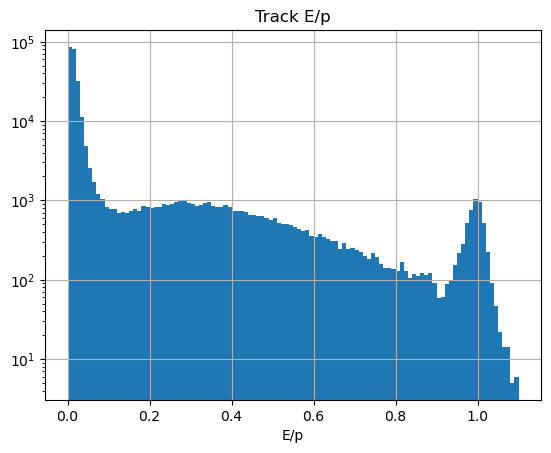

In [13]:
all_tracks["eop"].hist(bins=110, range=(0,1.1))
plt.yscale("log")
plt.title("Track E/p")
plt.xlabel("E/p")

We can observe here three distinct regions:
 - E/p < 0.1: this will correspond mostly to muons (with a contribution from pions)
 - 0.1 < E/p < 0.9: this will correspond mostly to pions
 - E/p > 0.9: this will correspond mostly to electrons

We can confirm this by doing the same plot for the tracks associated with each of the rich hypothesis (in the efficient RICH momentum range).

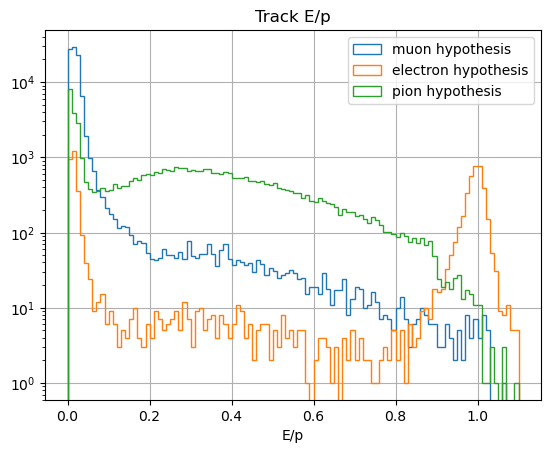

In [14]:
# Select tracks in the efficient RICH range
rich_eff_tracks = all_tracks[(all_tracks["momentum_mag"]>15000) & (all_tracks["momentum_mag"]<40000)]

# Split based on rich hypotesis
e_tracks = rich_eff_tracks.loc[rich_eff_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["e"]]
pi_tracks = rich_eff_tracks.loc[rich_eff_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["pi"]]
mu_tracks = rich_eff_tracks.loc[rich_eff_tracks["rich_hypothesis"]==constants.rich_hypothesis_map["mu"]]

# Plot the tracks
mu_tracks["eop"].hist(bins=110, range=(0,1.1), label="muon hypothesis", histtype="step")
e_tracks["eop"].hist(bins=110, range=(0,1.1), label="electron hypothesis", histtype="step")
pi_tracks["eop"].hist(bins=110, range=(0,1.1), label="pion hypothesis", histtype="step")
plt.yscale("log")
plt.title("Track E/p")
plt.xlabel("E/p")
_ = plt.legend()

The plot above roughly confirms what was said above about the three regions. However we clearly have some cross-category contamination. This will be the topic of the next section.

Generally the conditions you want to apply on the E/p for identification purposes depends on your intent (selection vs. rejection - or in other terms purity vs. efficiency)[<sup>1</sup>](#fn1). For example if you want to select electrons, you will want to make a tight cut on the E/p to make sure your sample is pure. You will use a condition such as $0.95 < E/p < 1.05$ even though this is clearly restrictive with respect to the plot above. But at the expense of some acceptance, we have a cleaner sample than if we had used a looser cut. On the other hand if you have a sample on which you want to exclude electrons, you will want to use something like $E/p > 0.9$ to define an electron, insuring that you are rejecting as many electrons as possible. We are going to use these numbers in the following and they are quite good cuts, but this will be demonstrated later.

<span id="fn1"><font size=2><sup>1</sup> Changing the "tight" direction of a cut depending on your intent is a rule that is generally valid and should be kept in mind.</font></span>

### Mis-identification

There are a few reasons why a particle would be mis-identified in a detector. We have already seen a few:
 - For the RICH, there is some overlap between hypothesis due to the resolution of the detector
 - For the RICH, there is degeneracy between hypothesis above some momentum
 - For the LKr, the process used for particle identification in the LKr is a stochastic process with overlapping probabilities between hypothesis.
 - For MUV3, some inefficiencies in the detector can lead to missing signal

In addition to this we must also consider pile-up. Events are not coming alone and well separated in the detector. A large fraction of the particle rate actually comes from a halo of muons generated in the target and beam line and transported by the beam line into the experiment. The probability of having a signal from such a muon at the same time as an event is non-negligible, and occasionally may be geometrically compatible. This can fake a MUV3 signal compatible with a non-muon track from the event.

All these issues can lead to a mis-identification in a single detector. Our best course of action to obtain the best PID possible is therefore to combine all the detectors to provide a stronger PID, rejecting events with conflicting PID (at the expense of some acceptance).

Let's have a more detailed look at mis-identification below.

As a starting point, let's define all the conditions that we will be using. In order to compare better between the detectors, we will also restrict ourselves to the RICH effective momentum range $15~\text{GeV} < p < 40~\text{GeV}$.

In [15]:
# Momentum range condition
momentum_condition = hlf.make_momentum_cut(15000, 40000)

# E/p conditions (note the overlap between pi and mu conditions)
eop_e_cond = hlf.make_eop_cut(0.95, 1.05)
eop_pi_cond = hlf.make_eop_cut(None, 0.95)
eop_mu_cond = hlf.make_eop_cut(None, 0.20)

# RICH conditions (automatically include the momentum range restriction, unless specifically changed)
rich_e_cond = hlf.make_rich_cut("e")
rich_pi_cond = hlf.make_rich_cut("pi")
rich_mu_cond = hlf.make_rich_cut("mu")

# MUV3 condition
muv3_mu_cond = hlf.make_muv3_cut(True, time_window=1.5)
muv3_notmu_cond = hlf.make_muv3_cut(False, time_window=2.5)

Then we can start looking at our tracks, starting with those identified as electrons in the RICH. We compare them to the PID result in the other detectors.

In [16]:
e_rich = hlf.select(all_tracks, [rich_e_cond])
eop_pid = hlf.identify(e_rich, {"e": [eop_e_cond, momentum_condition], "other": [eop_pi_cond, momentum_condition]}) # Use only the pi condition, which is less restrictive than the mu condition.
(eop_pid.sum()/len(e_rich))

e        0.497625
other    0.493321
dtype: float64

We see that in this case the rich is globally not doing a great job at PID. Let's have a look at the E/p values for these tracks.

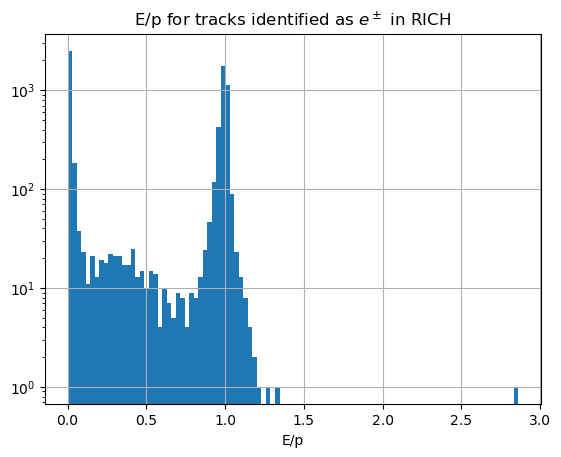

In [17]:
# Plot E/p
e_rich["eop"].hist(bins=100)
plt.yscale("log")
plt.title("E/p for tracks identified as $e^\pm$ in RICH")
_ = plt.xlabel("E/p")

We can see a clear electron component in the peak around $E/p=1$, but we also have a sizable component detected as MIPs which can clearly not be electrons. Let's look at the E/p as a function of the momentum.

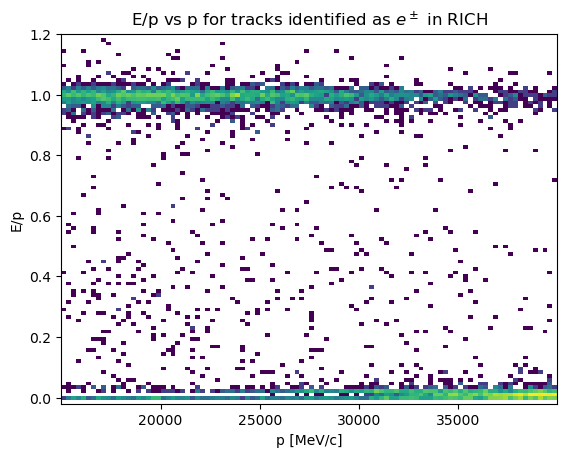

In [18]:
# Plot E/p vs p
_ = plt.hist2d(e_rich["momentum_mag"], e_rich["eop"], cmin=1, bins=(100,100), range=(None, (-0.02, 1.2)), norm=mpl.colors.LogNorm())
plt.title("E/p vs p for tracks identified as $e^\pm$ in RICH")
plt.xlabel("p [MeV/c]")
_ = plt.ylabel("E/p")

This is becoming clearer now that those electrons with very low E/p identified by the RICH as electrons are in fact at high momentum where we start to lose PID capabilities. Instead of looking at the global mis-identification between the RICH and E/p techniques, we can look at it as a function of momentum.

(0.0, 1.1)

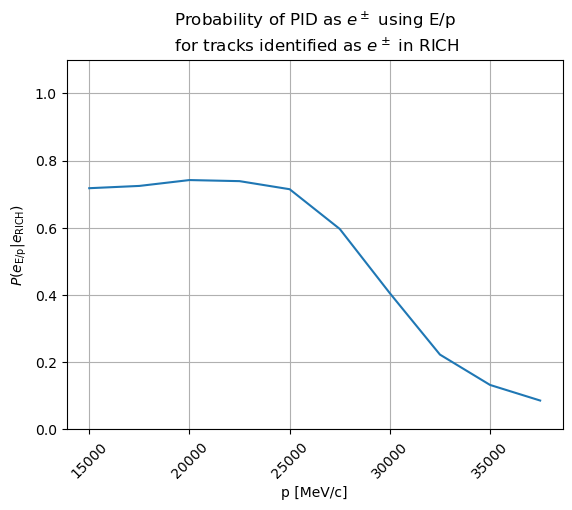

In [19]:
# Include the E/p PID result in the tracks dataframe
e_rich_wpid = e_rich.merge(eop_pid, left_index=True, right_index=True)

# Create a categorization in range of momentum in steps of 2.5 GeV
df_cut = pd.cut(e_rich_wpid["momentum_mag"], np.arange(15000,42500, 2500))

# Group the tracks in each category, then count the number of tracks identified by E/p as e or other and the total number of tracks
pid = e_rich_wpid[["e", "other", "index"]].groupby(df_cut).agg({"e": "sum", "other": "sum", "index": "count"})
pid.index = pid.index.categories.left # This is to remember only the lower edge of each category for a better display

# Plot the fraction of tracks identified by E/p as e wrt. to total number of tracks. We don't care about other here, also that essentially 1-e
pid["e"].div(pid["index"], axis=0).plot()
plt.xticks(rotation = 45)
plt.title("Probability of PID as $e^\pm$ using E/p\n for tracks identified as $e^\pm$ in RICH")
plt.ylabel(r"$P(e_\mathrm{E/p}|e_\mathrm{RICH})$")
plt.xlabel("p [MeV/c]")
plt.grid("both")
plt.ylim(0,1.1)

We can now clearly see the dependency. The E/p technique agrees in >70% of the cases with the RICH hypothesis up to 25 GeV/c, but then plumets quickly to nothing at 40 GeV/c.

We can play a similar exercise for tracks identified as muons or pions in the RICH

In [20]:
# Select tracks identified as muons in RICH, perform the E/p PID and plot the fraction
mu_rich = hlf.select(all_tracks, [rich_mu_cond])
# In the "other" condition below, we just want to exclude what we defined as muon (eop_pi_cond PID would actually include muons too, and electrons would be completely excluded)
eop_pid = hlf.identify(mu_rich, {"mu": [eop_mu_cond, momentum_condition], "other": [hlf.make_eop_cut(0.2, None), momentum_condition]})
# Plot the fraction of each category
(eop_pid.sum()/len(mu_rich))

mu       0.977778
other    0.022222
dtype: float64

(0.0, 1.1)

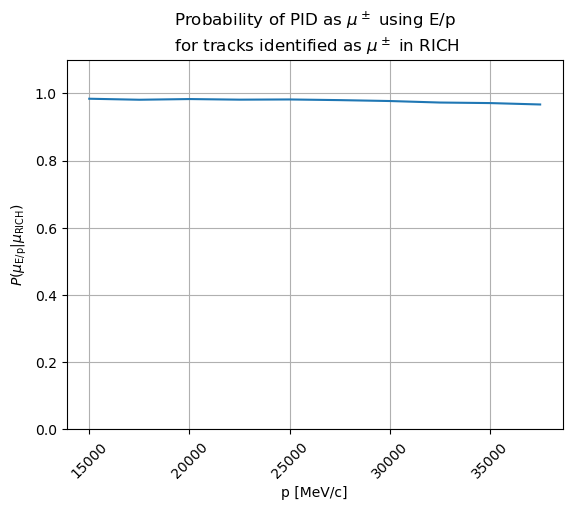

In [21]:
# Include the E/p PID result in the tracks dataframe
mu_rich_wpid = mu_rich.merge(eop_pid, left_index=True, right_index=True)

# Create a categorization in range of momentum in steps of 2.5 GeV
df_cut = pd.cut(mu_rich_wpid["momentum_mag"], np.arange(15000,42500, 2500))

# Group the tracks in each category, then count the number of tracks identified by E/p as mu or other and the total number of tracks
pid = mu_rich_wpid[["mu", "other", "index"]].groupby(df_cut).agg({"mu": "sum", "other": "sum", "index": "count"})
pid.index = pid.index.categories.left # This is to remember only the lower edge of each category for a better display

# Plot the fraction of tracks identified by E/p as mu wrt. to total number of tracks. We don't care about other here, also that essentially 1-e
pid["mu"].div(pid["index"], axis=0).plot()
plt.xticks(rotation = 45)
plt.title("Probability of PID as $\mu^\pm$ using E/p\n for tracks identified as $\mu^\pm$ in RICH")
plt.ylabel(r"$P(\mu_\mathrm{E/p}|\mu_\mathrm{RICH})$")
plt.xlabel("p [MeV/c]")
plt.grid("both")
plt.ylim(0,1.1)

In [22]:
# Select tracks identified as muons in RICH, perform the E/p PID and plot the fraction
pi_rich = hlf.select(all_tracks, [rich_pi_cond])
# In the "pi" condition below, we also include mu as E/p technique does not allow to separate pions from muons
eop_pid = hlf.identify(pi_rich, {"pi": [eop_pi_cond, momentum_condition], "e": [eop_e_cond, momentum_condition]})
# Plot the fraction of each category
(eop_pid.sum()/len(pi_rich))

pi    0.997622
e     0.002032
dtype: float64

(0.0, 1.1)

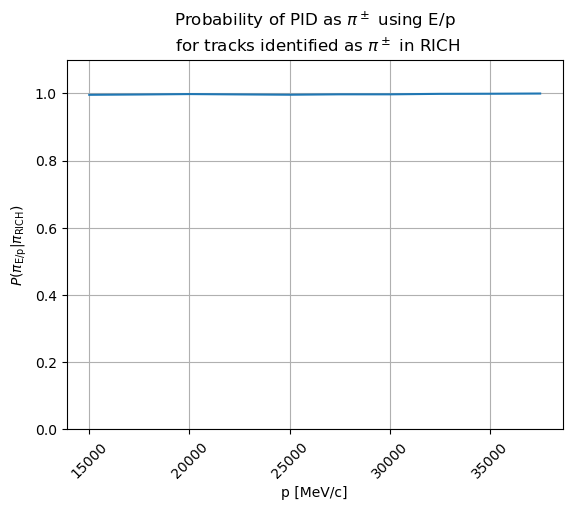

In [23]:
# Include the E/p PID result in the tracks dataframe
pi_rich_wpid = pi_rich.merge(eop_pid, left_index=True, right_index=True)

# Create a categorization in range of momentum in steps of 2.5 GeV
df_cut = pd.cut(pi_rich_wpid["momentum_mag"], np.arange(15000,42500, 2500))

# Group the tracks in each category, then count the number of tracks identified by E/p as pi or other and the total number of tracks
pid = pi_rich_wpid[["pi", "e", "index"]].groupby(df_cut).agg({"pi": "sum", "e": "sum", "index": "count"})
pid.index = pid.index.categories.left # This is to remember only the lower edge of each category for a better display

# Plot the fraction of tracks identified by E/p as pi wrt. to total number of tracks. We don't care about other here, also that essentially 1-e
pid["pi"].div(pid["index"], axis=0).plot()
plt.xticks(rotation = 45)
plt.title("Probability of PID as $\pi^\pm$ using E/p\n for tracks identified as $\pi^\pm$ in RICH")
plt.ylabel(r"$P(\pi_\mathrm{E/p}|\pi_\mathrm{RICH})$")
plt.xlabel("p [MeV/c]")
plt.grid("both")
plt.ylim(0,1.1)

As you can see above, the RICH is doing much better at identifying the pions and muons than the electrons.

After having compared performances of the RICH and E/p (LKr), we can next compare the performance of the MUV3 with respect to both RICH and LKr.

In [24]:
# Select tracks identified as muons in MUV3, perform the combined E/p and RICH PID and plot the fraction
mu_muv = hlf.select(all_tracks, [muv3_mu_cond, momentum_condition])
eop_pid = hlf.identify(mu_muv, {"pi": [eop_pi_cond, momentum_condition, rich_pi_cond], "e": [eop_e_cond, momentum_condition, rich_e_cond], "mu": [eop_mu_cond, momentum_condition, rich_mu_cond]})
# Plot the fraction of each category
(eop_pid.sum()/len(eop_pid))

pi    0.038906
e     0.000032
mu    0.935334
dtype: float64

(0.0, 1.1)

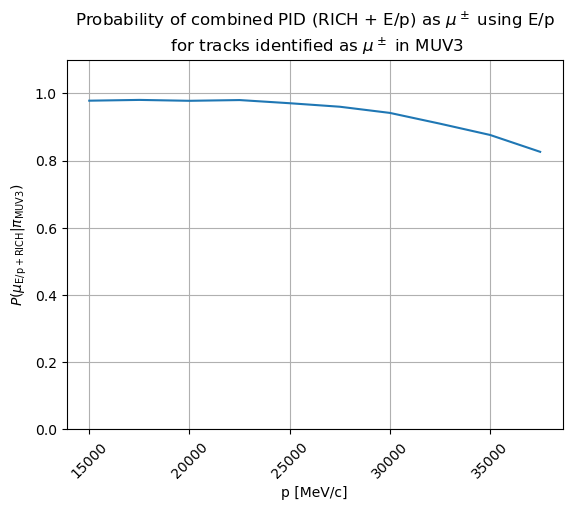

In [25]:
# Include the E/p PID result in the tracks dataframe
mu_muv_wpid = mu_muv.merge(eop_pid, left_index=True, right_index=True)

# Create a categorization in range of momentum in steps of 2.5 GeV
df_cut = pd.cut(mu_muv_wpid["momentum_mag"], np.arange(15000,42500, 2500))

# Group the tracks in each category, then count the number of tracks identified by E/p as pi, e, or muv and the total number of tracks
pid = mu_muv_wpid[["pi", "e", "mu", "index"]].groupby(df_cut).agg({"pi": "sum", "e": "sum", "mu": "sum", "index": "count"})
pid.index = pid.index.categories.left # This is to remember only the lower edge of each category for a better display

# Plot the fraction of tracks identified by E/p as mu wrt. to total number of tracks.
pid["mu"].div(pid["index"], axis=0).plot()
plt.xticks(rotation = 45)
plt.title("Probability of combined PID (RICH + E/p) as $\mu^\pm$ using E/p\n for tracks identified as $\mu^\pm$ in MUV3")
plt.ylabel(r"$P(\mu_\mathrm{E/p+RICH}|\pi_\mathrm{MUV3})$")
plt.xlabel("p [MeV/c]")
plt.grid("both")
plt.ylim(0,1.1)